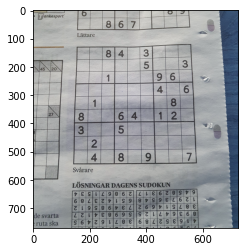

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
import hough


image_path = Path(os.path.abspath('')).joinpath("example.png")
assert image_path.is_file()
img = cv2.imread(str(image_path))
plt.imshow(img)

Start
Accumulating
done


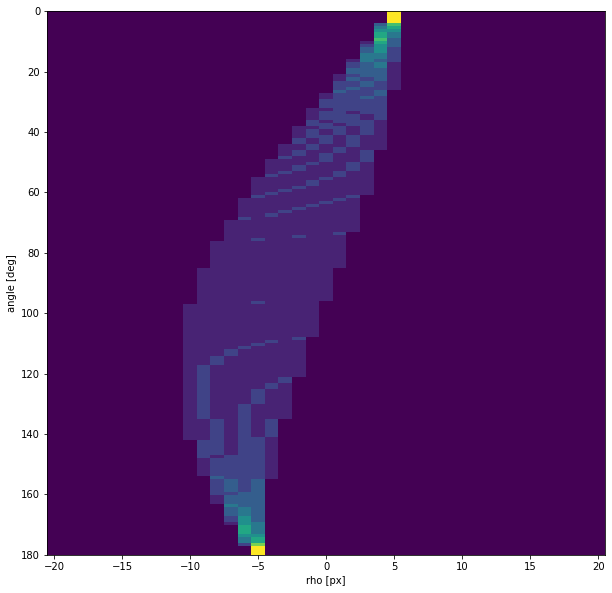

In [2]:
fig = plt.figure()
fig.set_size_inches(10, 10)
single_line = np.zeros((10, 10), np.uint8)
single_line[:, 5] = 1
acc2 = hough.houghaccum(single_line)
rows, cols = acc2.shape
ax = plt.gca()
ax.imshow(acc2, extent=[-cols/2, cols/2, rows, 0])
ax.set_xlabel("rho [px]")
ax.set_ylabel("angle [deg]")
ax.set_aspect(aspect="auto")


-1

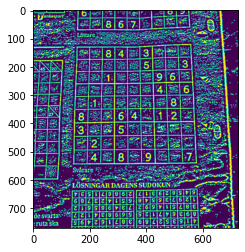

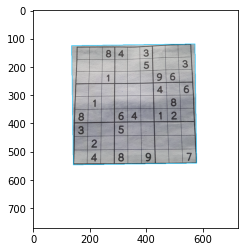

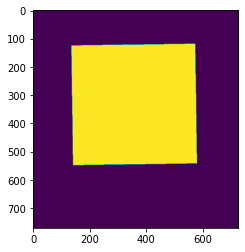

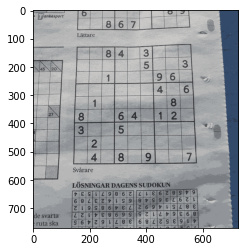

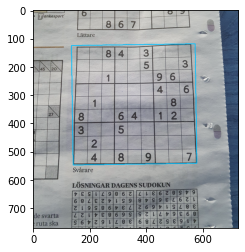

In [3]:
import cv2
import numpy as np

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = image.reshape((w*h, 3)).astype(np.float32)

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
img2 = img.copy()
kmeans = kmeans_color_quantization(img2, clusters=8)

# Convert to grayscale, Gaussian blur, adaptive threshold
gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,2)

# Draw largest enclosing rectangle onto a mask
mask = np.zeros(img2.shape[:2], dtype=np.uint8)
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img2,[box],0, color=(0,191,255), thickness=2)
    cv2.drawContours(mask,[box],0, color=255, thickness=-1)
    break

# Bitwise-and for result
result = cv2.bitwise_and(img2, img2, mask=mask)
result[mask==0] = (255,255,255)

plt.figure()
plt.imshow(thresh)
plt.figure()
plt.imshow(result)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(kmeans)
plt.figure()
plt.imshow(img2)
cv2.waitKey()

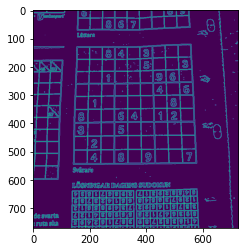

In [4]:
img_canny = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 150, 200)
plt.imshow(img_canny)

In [5]:
accum = hough.houghaccum(img_canny)

Start
Accumulating
done


Text(0.5, 0, 'Offset [px]')

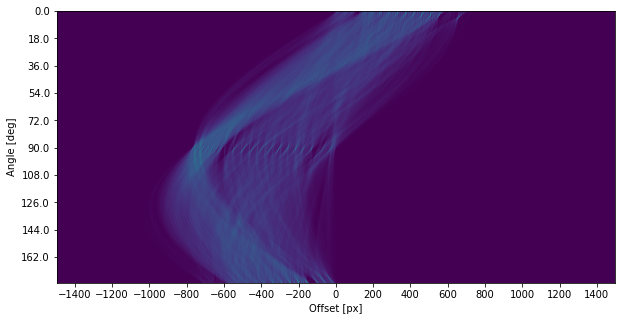

In [6]:
import scipy.ndimage

fig = plt.figure()
fig.set_size_inches(10, 5)
local_maxes = scipy.ndimage.maximum_filter(accum, size=5)
accum_nonzero = accum.copy()
accum_nonzero[accum == 0] = 1
y, x = accum.shape
plt.imshow(accum, extent=[-x/2, x/2, 180-1, 0])  #, norm=LogNorm(vmin=1, vmax=1e2))
ax = plt.gca()
ax.set_aspect(aspect="auto")
h, w = accum.shape
xs = np.arange(0, w, w/5)
ys = np.arange(0, h, h/10)
ax.set_yticks(ys, [str(y / 1) for y in ys])
ax.locator_params(nbins=20)
ax.set_ylabel("Angle [deg]")
ax.set_xlabel("Offset [px]")

(array([0.69153565, 0.69581609, 0.70146456, 0.70583595, 0.70964119,
        0.71316801, 0.71662057, 0.72013253, 0.72382455, 0.72763722,
        0.731229  , 0.7346927 , 0.73811371, 0.74126557, 0.74430791,
        0.74717948, 0.75003248, 0.75248826, 0.75478254, 0.75688749,
        0.75895346, 0.76090992, 0.76286266, 0.76475414, 0.76646186,
        0.76811761, 0.7698903 , 0.77164628, 0.77337256, 0.77518794,
        0.77695692, 0.77876302, 0.78064522, 0.78251443, 0.78453771,
        0.78661853, 0.78872534, 0.79097136, 0.793416  , 0.79581423,
        0.79822731, 0.8007759 , 0.80340245, 0.80619605, 0.80908433,
        0.81208583, 0.81528409, 0.8186754 , 0.82225048, 0.8259592 ,
        0.82976445, 0.83369591, 0.83774989, 0.84184657, 0.84610287,
        0.85037403, 0.8548735 , 0.85914094, 0.86339354, 0.86758302,
        0.87166299, 0.87572439, 0.87975795, 0.88379337, 0.88760975,
        0.891402  , 0.89504204, 0.89840551, 0.90173742, 0.90499694,
        0.90806712, 0.91093312, 0.91373415, 0.91

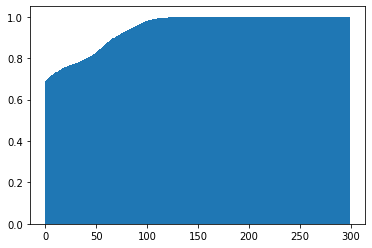

In [7]:
plt.hist(accum.flatten(), bins=range(0, 300), cumulative=True, density=True)

[  2  45  91 135]


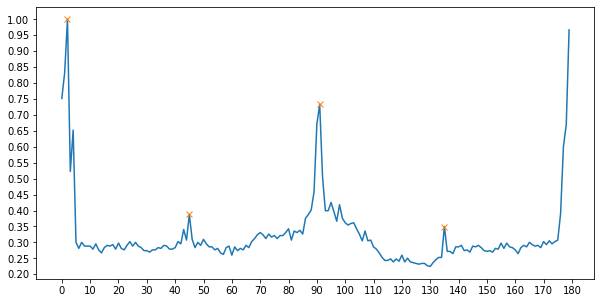

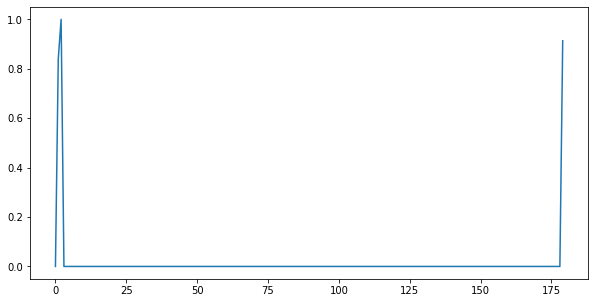

In [8]:
import scipy.signal

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.locator_params(nbins=20)
ys1 = np.amax(accum, axis=1)
angles = np.arange(180)
peaks, _ = scipy.signal.find_peaks(ys1, distance=30, prominence=10, width=(None, 5))
print(peaks)
plt.plot(ys1 / np.amax(ys1))
plt.plot(peaks, ys1[peaks] / np.amax(ys1), 'x')
fig = plt.figure()
fig.set_size_inches(10, 5)
thresh = np.amax(accum.flatten()) * 0.8
accum2 = accum.copy()
accum2[accum < thresh] = 0
ys2 = np.sum(accum2, axis=1)
plt.plot(ys2 / np.amax(ys2))

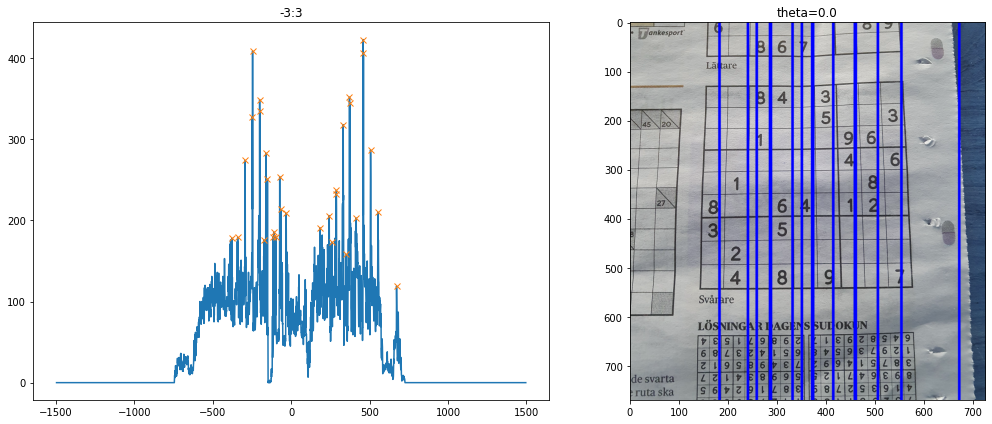

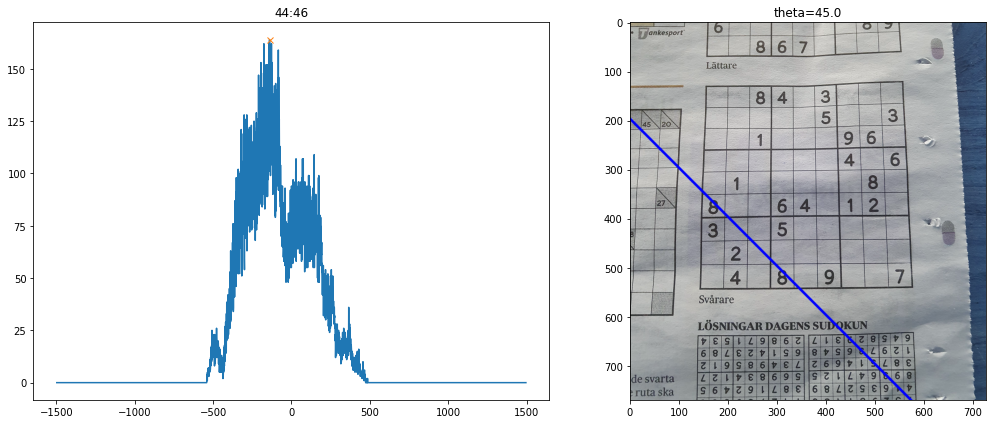

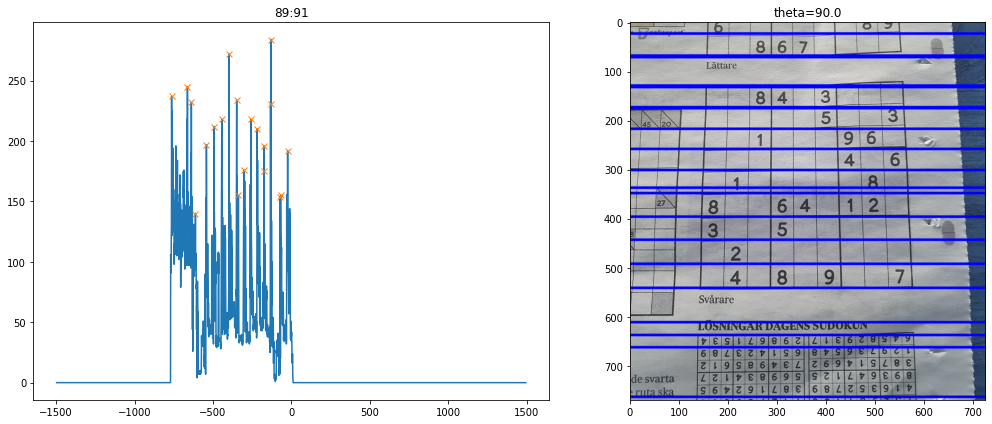

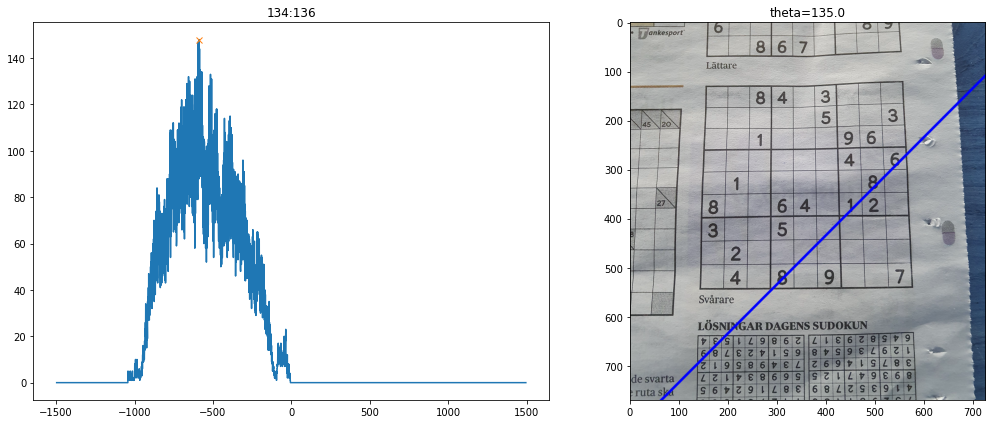

In [9]:
import scipy.signal
import math

rows, cols = accum.shape
tops = ((0, 3), (45, 1), (90, 1), (135, 1))
for mid, width in tops:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    a = mid - width
    b = mid + width
    if a < 0:
        acc = np.vstack((accum[a:], accum[0:b]))
    elif b > rows:
        acc = np.vstack((accum[a:], accum[0:b-rows]))
    else:
        acc = accum[a:b]
    ys = np.amax(acc, axis=0)
    # ys_bg = scipy.signal.medfilt(ys, 11)
    xs = np.arange(len(ys))
    xs = xs - len(xs) / 2
    y_max = np.amax(ys)
    ax1.plot(xs, ys)
    ax1.set_title(f"{a}:{b}")
    fig.set_size_inches(15, 6)
    fig.set_tight_layout(True)
    img_copy = img.copy()

    theta = sum((a, b)) / 2
    rhos, _ = scipy.signal.find_peaks(ys, prominence=100)
    ax1.plot(xs[rhos], ys[rhos], 'x')
    for rho in xs[rhos]:
        a = math.cos(theta * math.pi / 180)
        b = -math.sin(theta * math.pi / 180)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*b), int(y0 - 1000*a))
        pt2 = (int(x0 - 1000*b), int(y0 + 1000*a))
        cv2.line(img_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    ax2.imshow(img_copy)
    ax2.set_title(f"theta={theta}")